## imports

In [1]:
%matplotlib inline
from eelbrain import *
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy
import os
import shutil
import time

# Load the data and make FFTs

In [ ]:
DRUM_path = '/Volumes/JOSHUA2/DRUM/MathLang/DRUM'
subject_data_folder = f'{DRUM_path}/subject_data'
subjects = [f for f in os.listdir(subject_data_folder) if f[0]=='R']
subjects.sort()
print(subjects)

fftSL_all = []
fftSM_all = []
fftCL_all = []
fftCM_all = []
for subject in subjects:
    print(subject)

    # Single Speaker ##################################################################
    epochsS = mne.read_epochs(f'{subject_data_folder}/{subject}/{subject}_single_speaker_meg-epo.fif')
    
    # fix info structure for bad_channels
    epochdataS = epochsS.get_data()[:,:157,:]
    infoS = epochsS.info
    sel_idx = []
    chs = []
    ch_names = []
    for i in range(157):
        if f'MEG {i+1:03d}' not in infoS['bads']:
            sel_idx.append(i)
            chs.append(infoS['chs'][i])
            ch_names.append(infoS['ch_names'][i])
    infoS['chs'] = chs
    infoS['ch_names'] = ch_names
    infoS['nchan'] = len(sel_idx)
    infoS['bads'] = []
    
    # load NDVar
    epoch_ndS = NDVar(epochdataS[:,sel_idx,:], (Case, load.fiff.sensor_dim(infoS), UTS(0,1/infoS['sfreq'],epochdataS.shape[2])))
    epoch_ndS = epoch_ndS.sub(time=(0,18))
    print(epoch_ndS)
    # sentence epochs
    megSL = combine([epoch_ndS[10:20], epoch_ndS[30:]])
    fftSL = concatenate(megSL,'time').fft() # concatenate and then FFT
    fftSL_all.append(fftSL)
    
    # equation epochs
    megSM = combine([epoch_ndS[:10], epoch_ndS[20:30]])
    fftSM = concatenate(megSM, 'time').fft()
    fftSM_all.append(fftSM)
    
    
    # Cocktail Party ##################################################################
    epochsC = mne.read_epochs(f'{subject_data_folder}/{subject}/{subject}_cocktail_party_meg-epo.fif')
    
    # fix info structure for bad_channels
    epochdataC = epochsC.get_data()[:,:157,:]
    infoC = epochsC.info
    sel_idx = []
    chs = []
    ch_names = []
    for i in range(157):
        if f'MEG {i+1:03d}' not in infoC['bads']:
            sel_idx.append(i)
            chs.append(infoC['chs'][i])
            ch_names.append(infoC['ch_names'][i])
    infoC['chs'] = chs
    infoC['ch_names'] = ch_names
    infoC['nchan'] = len(sel_idx)
    infoC['bads'] = []
    
    # load NDVar
    epoch_ndC = NDVar(epochdataC[:,sel_idx,:], (Case, load.fiff.sensor_dim(infoC), UTS(0,1/infoC['sfreq'],epochdataC.shape[2])))
    epoch_ndC = epoch_ndC.sub(time=(0,18))
    print(epoch_ndC)
    # sentence epochs
    megCL = combine([epoch_ndC[:6], epoch_ndC[12:18], epoch_ndC[24:30], epoch_ndC[36:42]])
    fftCL = concatenate(megCL,'time').fft() # concatenate and then FFT
    fftCL_all.append(fftCL)
    
    # equation epochs
    megCM = combine([epoch_ndC[6:12], epoch_ndC[18:24], epoch_ndC[30:36], epoch_ndC[42:48]])
    fftCM = concatenate(megCM, 'time').fft()
    fftCM_all.append(fftCM)

    
fftSL_all = combine(fftSL_all)
fftSM_all = combine(fftSM_all)
fftCL_all = combine(fftCL_all)
fftCM_all = combine(fftCM_all)

# # change units to fT/sqrt(Hz)
fftSL_all = fftSL_all/np.sqrt(len(fftSL_all.frequency)/megSL.time.tstep)
fftSM_all = fftSM_all/np.sqrt(len(fftSM_all.frequency)/megSM.time.tstep)
fftCL_all = fftCL_all/np.sqrt(len(fftCL_all.frequency)/megCL.time.tstep)
fftCM_all = fftCM_all/np.sqrt(len(fftCM_all.frequency)/megCM.time.tstep)

# Run Frequency Tests

In [ ]:
fftsAll = [fftSL_all, fftSM_all, fftCL_all, fftCM_all]
titles = ['Math Single Speaker', 'Language Single Speaker', 'Cocktail Attend Lang', 'Cocktail Attend Math']
sb = 5 #sidebands
gap = 0 #gap between target and sideband
ifreqs = [0.55555, 0.66666, 2.66666, 2.77777]
    
for ffts1, tstr in zip(fftsAll, titles):
    
    # permutation test with max-t method
    ffts = ffts1.mean('sensor').sub(frequency=(0.3, 3))
    f_targets = []
    f_sidemeans = []
    for f in range(sb+gap, len(ffts.frequency)-sb-gap):
        f_targ = ffts.x[:,f]
        f_targets.append(f_targ)
        f_sides = []
        for i in range(sb):
            f_sides.append(ffts.x[:,f-(gap+i)])
            f_sides.append(ffts.x[:,f+(gap+i)])
        f_sidemean = np.mean(np.asarray(f_sides), axis=0)
        f_sidemeans.append(f_sidemean)
    
    v_true, pvals, vs = mne.stats.permutation_t_test(np.asarray(f_targets).T - np.asarray(f_sidemeans).T, tail=1)
    print(tstr, 'permutation test with max-t method of difference of amplitudes')
    print('significant frequencies:')
    print([(f'{f:.3f} Hz', p, t) for f, p, t in zip(ffts.frequency.values[sb+gap:-sb-gap], pvals, v_true) if p < 0.05])
    print('\nfrequencies of interest')
    for ifreq in ifreqs:
        idx = np.argmin([np.abs(f-ifreq) for f in ffts.frequency.values[sb+gap:-sb-gap]])
        print(f'{ifreq:.3f} Hz, {pvals[idx]}, {v_true[idx]}')
    print('\n')

# plot Spectra

/Users/pranjeevan/anaconda/envs/eelmaster/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


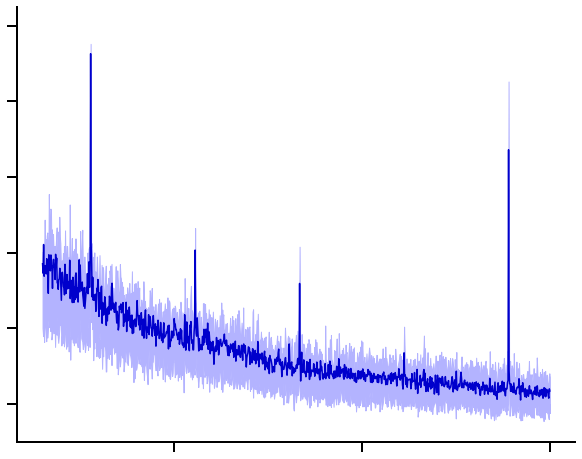

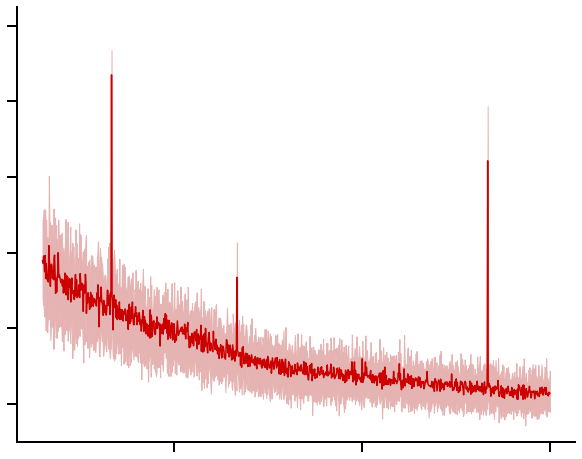

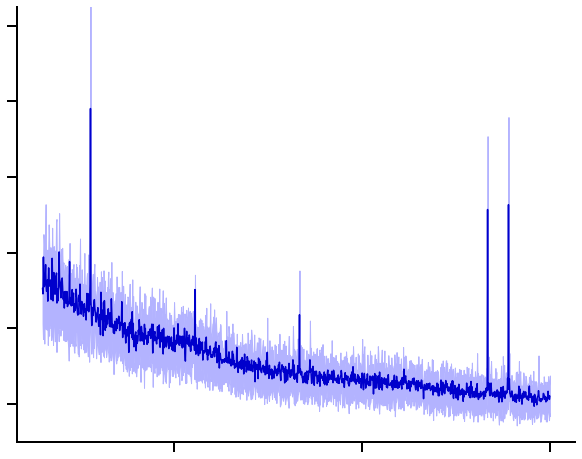

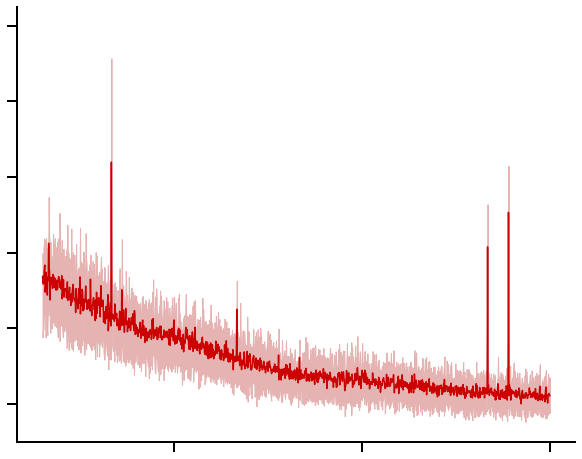

In [10]:
SL = fftSL_all.mean('sensor').sub(frequency=(0.3,3))
SM = fftSM_all.mean('sensor').sub(frequency=(0.3,3))
CL = fftCL_all.mean('sensor').sub(frequency=(0.3,3))
CM = fftCM_all.mean('sensor').sub(frequency=(0.3,3))

FFTS = [SM.copy(), SL.copy(), CM.copy(), CL.copy()]
colors = [(0,0,0.8), (0.8,0,0), (0,0,0.8), (0.8,0,0)]
colors2 = [(0.7,0.7,1), (0.9,0.7,0.7), (0.7,0.7,1), (0.9,0.7,0.7)]

ifreqs = [1/(5*0.36), 1/(4*0.375), 1/0.36, 1/0.375]
icolors = [(0,0,0.8,0.2), (0.8,0,0,0.2), (0,0,0.8,0.2), (0.8,0,0,0.2)]
savestrs = ['SingleM','SingleL','CocktailM','CocktailL']
sidebands = 5

for FFT11, color, color2, savestr in zip(FFTS, colors, colors2, savestrs):
    FFT1 = FFT11
    vmax = 1.25e-13
    FFT = FFT1.mean('case')
    ff2 = FFT.frequency.values
    xx2 = FFT.x

    FFT = NDVar(xx2, Scalar('frequency', ff2))
    fig = plt.figure(figsize=(10,8))
    q1 = np.quantile(FFT1.x, 0.25, axis=0)
    xx2 = q1
    Q1 = NDVar(xx2, Scalar('frequency', ff2))    
    q3 = np.quantile(FFT1.x, 0.75, axis=0)
    xx2 = q3#[]
    Q3 = NDVar(xx2, Scalar('frequency', ff2))
    plt.fill_between(FFT.frequency.values, Q1.x, Q3.x, color=color2)
    fres = FFT.frequency.values[1]-FFT.frequency.values[0]
    plt.plot(FFT.frequency.values, FFT.x, color=color)
    ax = plt.axes()
    sidew = sidebands * (FFT.frequency.values[1]-FFT.frequency.values[0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(length=10)
    ax.yaxis.set_tick_params(length=10)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    plt.ylim([0.1e-13, 1.25e-13])
    plt.gca().set_yticklabels([])

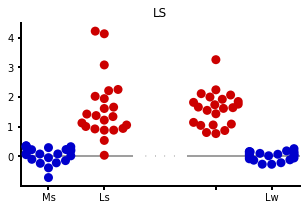

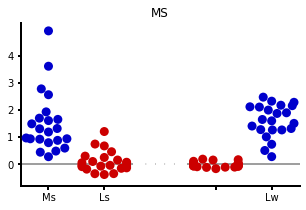

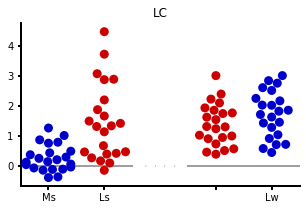

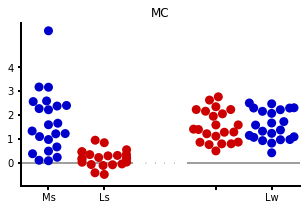

In [11]:
freqs = [0.55555, 0.666666, 2.66666, 2.777777]

points = {}

fv = fftSM_all.frequency.values[1]
boxX = fftSM_all
aa = [(boxX.sub(frequency=f)-0.5*(boxX.sub(frequency=(f-5*fv,f-fv)).mean('frequency')+boxX.sub(frequency=(f+fv,f+5*fv)).mean('frequency'))).mean('sensor').x for f in freqs]
points['MS'] = aa

boxX = fftSL_all.mean('sensor')
aa = [boxX.sub(frequency=f).x-0.5*(boxX.sub(frequency=(f-5*fv,f-fv)).mean('frequency').x+boxX.sub(frequency=(f+fv,f+5*fv)).mean('frequency').x) for f in freqs]
points['LS'] = aa


fv = fftCM_all.frequency.values[1]
boxX = fftCM_all.mean('sensor')
aa = [boxX.sub(frequency=f).x-0.5*(boxX.sub(frequency=(f-5*fv,f-fv)).mean('frequency').x+boxX.sub(frequency=(f+fv,f+5*fv)).mean('frequency').x) for f in freqs]
points['MC'] = aa

boxX = fftCL_all.mean('sensor')
aa = [boxX.sub(frequency=f).x-0.5*(boxX.sub(frequency=(f-5*fv,f-fv)).mean('frequency').x+boxX.sub(frequency=(f+fv,f+5*fv)).mean('frequency').x) for f in freqs]
points['LC'] = aa

import pandas as pd
import seaborn as sns

dfs = {} 
mins = []
maxs = []
sds = []
points1 = {}
for k in points.keys():
    sd = np.std(np.reshape(np.asarray(points[k]), [-1]))
    sds.append(sd)
    points1[k] = [p/sd for p in points[k]]
    points1[k] = [points1[k][0], points1[k][1], np.zeros(22), points1[k][2], points1[k][3]]
    dfs[k] = pd.DataFrame(np.asarray(points1[k]).T, columns=['Ms', 'Ls', '', 'Lw', 'Mw']) 
    mins.append(np.min(np.asarray(points1[k])))
    maxs.append(np.max(np.asarray(points1[k])))
    

for i, k in zip([1,2,3,4],['LS','MS','LC','MC']): 
    plt.figure(figsize=(5,3)) 
    ax = plt.gca()
    sns.swarmplot(data=dfs[k], ax=ax, size=9,
                  palette={'Ms':(0,0,0.8),'Ls':(0.8,0,0), '': [1,1,1], 'Lw':(0.8,0,0),'Mw':(0,0,0.8)}) 
    plt.title(k) 
    plt.gca().spines['right'].set_visible(False) 
    plt.gca().spines['top'].set_visible(False) 
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().set_xticks([0,1,3,4])
    plt.gca().xaxis.set_tick_params(width=2)
    plt.gca().yaxis.set_tick_params(width=2)
    plt.gca().set_yticks([0, 1, 2, 3, 4])
#     plt.gca().set_yticklabels(['0','','',''])
#     plt.gca().set_ylim([])
    plt.gca().axhline(0, color='k', alpha=0.5) 